In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from albumentations import *
from torchvision import transforms
from torch.utils.data import DataLoader
from glob import glob
import utils_rs

ModuleNotFoundError: No module named 'utils_rs'

In [1]:
def get_aug():
    trans_ = Compose([
        # affine
        VerticalFlip(p=0.5),
		HorizontalFlip(p=0.5),
        RandomRotate90(p=0.5),
        #RandomBrightnessContrast(p=0.5),
    ])

    return trans_ 

def build_transformer():
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return transformer

class building_dataset():
    def __init__(self, img_dir,mask_dir, phase, tfms=get_aug()):
        self.phase = phase

        self.image_files = sorted(glob( os.path.join( img_dir , "*.png")) )
        self.mask_files  = sorted(glob( os.path.join( mask_dir , "*.png")))

        assert len(self.image_files) == len(self.mask_files)

        self.IMAGE_SIZE = 224 #224 => 250
        self.tfms = tfms

        self.ISAID_PALETTE = {
            0: (0, 0, 0), 1: (0, 0, 63), 2: (0, 63, 63), 3: (0, 63, 0), 4: (0, 63, 127),
            5: (0, 63, 191), 6: (0, 63, 255), 7: (0, 127, 63), 8: (0, 127, 127),
            9: (0, 0, 127), 10: (0, 0, 191), 11: (0, 0, 255), 12: (0, 191, 127),
            13: (0, 127, 191), 14: (0, 127, 255), 15: (0, 100, 155)}

        self.ISAID_CLASSES = ('background', 'ship', 'store_tank', 'baseball_diamond',
            'tennis_court', 'basketball_court', 'Ground_Track_Field',
            'Bridge', 'Large_Vehicle', 'Small_Vehicle', 'Helicopter',
            'Swimming_pool', 'Roundabout', 'Soccer_ball_field', 'plane',
            'Harbor')
        
        self.trans_ = Compose([
                # affine
                VerticalFlip(p=0.8),
                HorizontalFlip(p=0.8),
                RandomRotate90(p=0.8),
                #RandomBrightnessContrast(p=0.5),
                ])



    def __len__(self):
        return len(self.image_files)

    def build_transformer_normalize(self):
      transformer = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ])
      return transformer

    def convert_to_target_(self, mask_image, IMAGE_SIZE):
        #print(mask_image.shape)
        mask_image = np.asarray(mask_image)

        canvas = np.zeros( (mask_image.shape[0],mask_image.shape[1]) ,  dtype=np.uint8)
        for k,v in self.ISAID_PALETTE.items():
            canvas[np.all(mask_image == v, axis=-1)] = k

        #-------
        #mask = np.argmax(canvas, axis=-1 )

        return canvas

    def __getitem__(self, index):

        # image
        image = cv2.imread( self.image_files[index] )
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, dsize=(self.IMAGE_SIZE,self.IMAGE_SIZE), interpolation=cv2.INTER_LINEAR)

        # mask
        mask = cv2.imread( self.mask_files[index] )
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = cv2.resize(mask, dsize=(self.IMAGE_SIZE,self.IMAGE_SIZE), interpolation=cv2.INTER_NEAREST) # inter nearest
        
        # build normalize
        normalizer = self.build_transformer_normalize()

        if self.phase=='train':

            augmented = self.trans_(image=image,mask=mask)
            image= augmented['image'], mask = augmented['mask']

            # normalize
            image = normalizer(image)

            mask = self.convert_to_target_(mask, self.IMAGE_SIZE)
           #target = torch.from_numpy(mask).long()
            return image, mask
    
        elif self.phase=='val':
          # normalize validation 할 때는 그냥 normalize 빼보자
           image = normalizer(image)

           mask = self.convert_to_target_2(mask_image, self.IMAGE_SIZE)
           target = torch.from_numpy(mask).long()
           return image, target



NameError: name 'Compose' is not defined

In [3]:
def collate_fn(batch):
    images = []
    targets = []
    for a, b in batch:
        
        images.append(a)
        targets.append(b)
    images = torch.stack(images, dim=0)
    targets = torch.stack(targets, dim=0)

    return images, targets

In [5]:
img_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/01.512_imgs"
mask_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/01.Models/04.SAM_fine/0.data/02.512_masks"

tr_dataset = building_dataset(img_dir=img_path, mask_dir=mask_path, phase="train", tfms=get_aug())
val_dataset = building_dataset(img_dir=img_path,mask_dir=mask_path, phase="val", tfms=get_aug())

In [23]:
img, mask = tr_dataset.__getitem__(21)

In [8]:
img.shape

torch.Size([3, 224, 224])

In [9]:
mask.shape

(224, 224, 3)

In [10]:
np.unique(mask)

array([  0, 127], dtype=uint8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


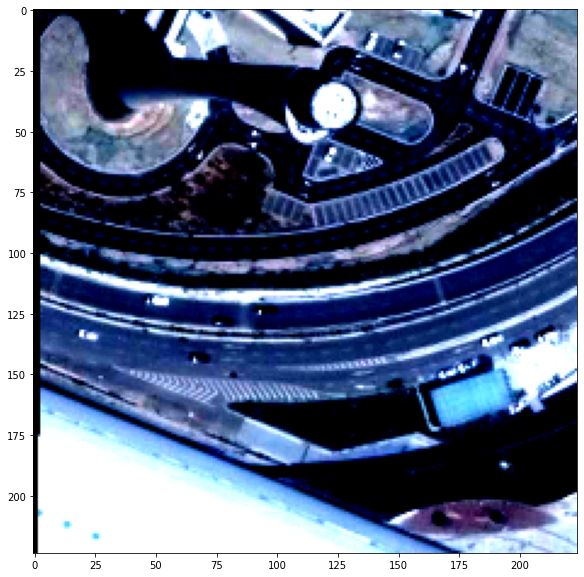

In [24]:
utils_rs.torch_display(img)

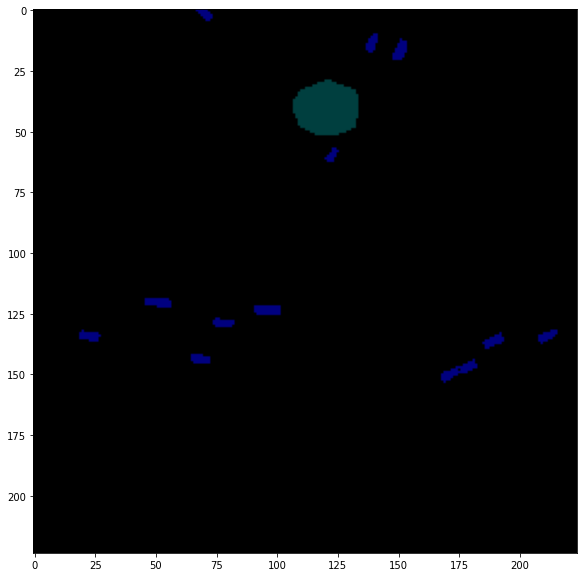

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(mask)